<h1> MSIN0114: Business Analytics Consulting Project/Dissertation 2021-22

<h1> Libraries imported

In [3]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait as W
from selenium.webdriver.support import expected_conditions as E
from selenium.webdriver import ActionChains
from selenium.webdriver import Chrome

In [4]:
import os
import csv
import glob
import time
import openpyxl
import datetime
from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")

In [9]:
#Import linear algebra and data manipulation
import numpy as np
np.random.seed(42)

import pandas as pd
pd.options.display.max_columns = 10
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Import plotting packages
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

# To plot pretty figures
import matplotlib as mpl


### Function for opening Selenium and getting HTML with Beautiful Soup 

In [ ]:
def getBeautySoup(url):
    driver = Chrome('./chromedriver')
    driver.get(url)
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    driver.close()
    return bs.prettify()

In [ ]:
getBeautySoup('https://worldpopulationreview.com/world-cities')

In [ ]:
print(bsMenu.prettify())

<h1> Data Exploration

In [6]:
location = pd.read_excel('./MEG Locations - May 2022.xlsx') 

location.drop('State',axis = 1, inplace = True)
location.dropna(inplace = True)
print(location.Country.unique())

['Switzerland' 'China' 'Nebraska' 'USA' 'Finland' 'UK' 'Canada'
 'Netherlands' 'Singapore' 'Belgium' 'Japan' 'Germany' 'Italy' 'Taiwan'
 'Austria' 'India' 'Sweden' 'Australia' 'UAE' 'Denmark' 'France'
 'Saudi Arabia' 'Russia' 'Spain' 'Malaysia' 'The Netherlands' 'Israel'
 'South Korea' 'Greece']


In [10]:
# Since Nebraska is one of the US State, it is not a country, we will replace it by "USA"
location = location.replace("Nebraska", "USA")
# There are 'Netherlands' and 'The Netherlands', we would group them as 'Netherlands'
location = location.replace('The Netherlands', 'Netherlands')
#Replace " " to "_" in Country for data analysis
location['Country'] = location['Country'].str.replace(" ", "_")
location

,City,Country
0,Geneva,Switzerland
1,Tianjin,China
2,Omaha,USA
3,Pittsburgh,USA
4,Charlestown,USA
...,...,...
230,Tokyo,Japan
232,Fukuoka,Japan
233,Tokyo,Japan
234,Münster,Germany


In [11]:
# Country list
countries = location.Country.unique().tolist()
#countries = [c.replace(" ", "_") for c in countries]
print(countries)
len(countries)

['Switzerland', 'China', 'USA', 'Finland', 'UK', 'Canada', 'Netherlands', 'Singapore', 'Belgium', 'Japan', 'Germany', 'Italy', 'Taiwan', 'Austria', 'India', 'Sweden', 'Australia', 'UAE', 'Denmark', 'France', 'Saudi_Arabia', 'Russia', 'Spain', 'Malaysia', 'Israel', 'South_Korea', 'Greece']


27

In [12]:
#Get Specific country
c = dict(tuple(location.groupby('Country')))

#Since we only want to focus on these 5 countries, we would concatenate a new country list
frames = [c['USA'] , c['UK'] , c['Canada'] , c['Italy'] , c['Switzerland']]
MEG = pd.concat(frames)

MEG.rename(columns = {"City" : "city" , "Country": "country"}, inplace = True)
MEG = MEG.drop_duplicates(subset = ['city'])
MEG

,city,country
2,Omaha,USA
3,Pittsburgh,USA
4,Charlestown,USA
6,Gainesville,USA
12,Seattle,USA
...,...,...
41,Bari,Italy
62,Milan,Italy
64,Venice,Italy
106,Rovereto,Italy


<h3> By City

In [13]:
cities = MEG.city.unique().tolist()
print(cities)
len(cities)

['Omaha', 'Pittsburgh', 'Charlestown', 'Gainesville', 'Seattle', 'Boulder', 'Cleveland', 'Grand Rapids', 'Redwood City', 'Royal Oak', 'West Haven', 'Cincinnati', 'Philadelphia', 'Phoenix', 'Dallas', 'Little Rock', 'Memphis', 'Houston', 'Austin', 'Fort Worth', 'Orlando', 'Cambridge', 'Summit', 'Secaucus', 'Bethesda', 'Albuquerque', 'Chicago', 'Milwaukee', 'Elk Grove Village', 'New York City', 'St. Louis', 'Winston-Salem', 'San Diego', 'Sacramento', 'Saint Paul', 'Athens', 'San Francisco', 'Kansas City', 'College Park', 'Tuscaloosa', 'Fayetteville', 'Detroit', 'Pasadena', 'Glasgow', 'Surrey', 'Nottingham', 'Oxford', 'Birmingham', 'Londonderry Derry', 'Cardiff', 'Liverpool', 'London', 'York', 'Toronto', 'Halifax', 'Montreal', 'Bari', 'Milan', 'Venice', 'Rovereto', 'Geneva']


61

# Helper Function for finding the downloaded file name 

In [18]:
# method to get the downloaded file name
def getFileName(waitTime):
    driver.execute_script("window.open()")
    # switch to new tab
    driver.switch_to.window(driver.window_handles[-1])
    download = driver.window_handles[-1]
    # navigate to chrome downloads
    driver.get('chrome://downloads')
    # define the endTime
    endTime = time.time() + waitTime
    while True:
        try:
            fileName = driver.execute_script("return document.querySelector('downloads-manager').shadowRoot.querySelector('#downloadsList downloads-item').shadowRoot.querySelector('div#content  #file-link').text")
            if fileName:
                return fileName  
        except:
            pass
        time.sleep(1)
        if time.time() > endTime:
            break


<h1> Web Scrapping

In [15]:
options = webdriver.ChromeOptions()

#options.add_argument("test-type")
#options.add_argument("--start-maximized")
#options.add_argument("--disable-web-security")
#options.add_argument("--disable-notifications")
#options.add_argument("--allow-running-insecure-content")
#options.add_argument("--disable-popup-blocking")
#prefs = {"profile.block_third_party_cookies": True,
#         "profile.default_content_setting_values.notifications" : 2, 
#         "profile.managed_default_content_settings.images": 2,

options.add_argument('--disable-blink-features=AutomationControlled')
options.add_argument('--ignore-certificate-errors')
options.add_argument('--ignore-ssl-errors')
prefs = {"profile.default_content_settings.popups": 0 ,
        "download.default_directory" : "/Users/yui/Documents/UCL/Dissertation/Final Report"}
options.add_experimental_option("prefs",prefs)
driver = Chrome('./chromedriver',options=options)

#soup = BeautifulSoup(driver.page_source)
#driver.manage().Cookies.DeleteAllCookies()


#driver.switch_to.frame(driver.find_element_by_css_selector('iframe[title="SP Consent Message"]'))

<h2> World City Population

In [19]:
driver.get("https://worldpopulationreview.com/world-cities")
time.sleep(3)

try:
    #driver.implicitly_wait(10)
    #driver.maximize_window()
    accept_button = driver.find_element_by_xpath('//*[@id="qc-cmp2-ui"]/div[2]/div/button[2]')
    accept_button.click()
except:
    pass 

try:
    downloadcsv = driver.find_element_by_xpath('//*[@id="countries"]/div[1]/div/div[1]/div/div[1]/a[1]')
    downloadcsv.click()
except:
    print("Fail to download csv")  

    
try:
    pop_file = getFileName(10)
    print(pop_file)
except:
    print("Failed to retrieve filename")

driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])
time.sleep(3)

csvData.csv


In [20]:
pop_df = pd.read_csv(pop_file) 
pop_df

,rank,Name,Country,Population,Prev,Growth
0,1,Tokyo,Japan,37274000,37339804,-0.002
1,2,Delhi,India,32065760,31181376,0.028
2,3,Shanghai,China,28516904,27795702,0.026
3,4,Dhaka,Bangladesh,22478116,21741090,0.034
4,5,Sao Paulo,Brazil,22429800,22237472,0.009
...,...,...,...,...,...,...
1182,1183,La Serena-Coquimbo,Chile,503013,493767,0.019
1183,1184,Zhuanghe,China,502143,484394,0.037
1184,1185,Latur,India,501664,490405,0.023
1185,1186,Douai-Lens,France,501583,500921,0.001


In [21]:
pop_df = pop_df.replace("United Kingdom", "UK")
pop_df = pop_df.replace("United States", "USA")

pop_df.drop(pop_df.iloc[:, 4:],axis = 1,inplace = True)
pop_df = pop_df.drop("rank", axis = 1)

#Rename the column to city for consistence
pop_df.rename(columns = {"Name": "city", "Country" : "country"}, inplace = True)

pop_df = pop_df[(pop_df.country=="USA")|(pop_df.country=="UK") | (pop_df.country=="Italy") | (pop_df.country=="Switzerland") | (pop_df.country=="Canada")]
pop_df


,city,country,Population
34,London,UK,9540576
44,New York City,USA,8177020
59,Toronto,Canada,6312974
97,Rome,Italy,4297877
99,Montreal,Canada,4276526
...,...,...,...
1123,Atlanta,USA,532695
1127,Sacramento,USA,531285
1156,London CA,Canada,514785
1158,Bournemouth,UK,514313


In [22]:
pd.DataFrame({'unique': pop_df.nunique(),
              'missing': pop_df.isna().sum(),
              'missing%': pop_df.isna().sum()/pop_df.count(),
              'type': pop_df.dtypes})

,unique,missing,missing%,type
city,84,0,0.000,object
country,5,0,0.000,object
Population,84,0,0.000,int64


In [23]:
# To remove Duplicates
pop_df.duplicated().sum()
pop_df.drop_duplicates(inplace=True)
# To remove NaN values
pop_df.isnull().sum()
pop_df.dropna(how='any',inplace=True)
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 34 to 1176
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city        84 non-null     object
 1   country     84 non-null     object
 2   Population  84 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.6+ KB


<h2> World GDP from World Bank
    

In [25]:
# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get("https://data.worldbank.org/indicator/NY.GDP.PCAP.CD")
time.sleep(5)

try:
    download_link = driver.find_element_by_xpath('//*[@id="mainChart"]/aside/div/div[2]/div/p/a[1]').click()
    time.sleep(3)
except:
    print("Fail")
    
try:
    gdp_file = getFileName(10)
    print(gdp_file)
except:
    print("Failed to retrieve filename")

driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])
time.sleep(2)

API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4251004.zip


In [26]:
with ZipFile(gdp_file, 'r') as zipObj:
    # Get a list of all archived file names from the zip
    listOfFileNames = zipObj.namelist()
    # Iterate over the file names
    for fileName in listOfFileNames:
      # Check filename endswith csv
        if not fileName.startswith('Metadata'):
        # Extract a single file called "gdp" from zip
            zipObj.extract(fileName, 'gdp')

# use glob to get all the csv files in the folder
path = os.getcwd()
csv_files = glob.glob(os.path.join("./gdp", "*.csv"))
  
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    world_gdp = pd.read_csv(f, skiprows = 4)
      
    # print the location and filename
    print('Location:', f)
    print('File Name:', f.split("\\")[-1])
      
    # print the content
    print('Content:')
    display(world_gdp)
    print()
    

Location: ./gdp/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4251004.csv
File Name: ./gdp/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_4251004.csv
Content:


,Country Name,Country Code,Indicator Name,Indicator Code,1960,...,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,...,30253.714,31135.884,23384.299,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,162.726,...,1541.032,1511.309,1360.879,1557.723,NaN
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773,...,485.668,494.179,516.748,NaN,NaN
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,107.931,...,1704.136,1777.853,1709.764,1774.921,NaN
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,...,2524.942,2177.799,1631.432,2137.909,NaN
...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,...,4384.049,4416.108,4310.811,4986.582,NaN
262,"Yemen, Rep.",YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,...,758.146,750.555,631.681,690.759,NaN
263,South Africa,ZAF,GDP per capita (current US$),NY.GDP.PCAP.CD,511.619,...,7005.095,6624.762,5655.868,6994.212,NaN
264,Zambia,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,232.189,...,1516.368,1305.001,985.132,1120.630,NaN


In [27]:
# Since only country name and the 2020 data are needed, 
# columns that are not relevant to the analysis are droped:                                         
cgdp = world_gdp.drop(world_gdp.iloc[:, 1:64],axis = 1)
cgdp = cgdp.drop(cgdp.iloc[:, -2:],axis = 1)

# Change to column name to indicate to unit
cgdp.rename(columns = {"Country Name": "country" ,"2020" :'2020 gdp by country, in USD$, current price'}, inplace = True)
cgdp = cgdp.replace("United Kingdom", "UK")
cgdp = cgdp.replace("United States", "USA")
cgdp.head()


,country,"2020 gdp by country, in USD$, current price"
0,Aruba,23384.299
1,Africa Eastern and Southern,1360.879
2,Afghanistan,516.748
3,Africa Western and Central,1709.764
4,Angola,1631.432


In [28]:
cgdp_df = cgdp[(cgdp.country=="USA")|(cgdp.country=="UK") | (cgdp.country=="Italy") | (cgdp.country=="Switzerland") | (cgdp.country=="Canada")]
cgdp_df

,country,"2020 gdp by country, in USD$, current price"
35,Canada,43258.264
37,Switzerland,87100.415
81,UK,41098.079
116,Italy,31834.973
251,USA,63027.680


<h2> Canada GDP by city

In [29]:
# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get("https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610046801")
time.sleep(5)

try:
    download_option = driver.find_element_by_id("downloadOverlayLink").click()
    time.sleep(3)
    #download_link = driver.find_element_by_xpath('//*[@id="downloadButtonOverlay"]/div[1]/div[1]/div/div[6]/a').click()
    download_link = driver.find_element_by_xpath('//*[@id="downloadAsDisplay"]')
    download_link.click()
    time.sleep(3)
except:
    pass  

try:
    canada_file = getFileName(10)
    print(canada_file)
    time.sleep(3)
except:
    print("Failed to retrieve filename")

driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])
time.sleep(2)

None


In [33]:
canada = pd.read_csv(canada_file, skiprows = 7, skipfooter = 9)
canada

,Geography,2014,2015,2016,2017,2018
0,NaN,Dollars,NaN,NaN,NaN,NaN
1,Canada,"1,867,752","1,856,814","1,886,103","1,991,534","2,083,379"
2,Newfoundland and Labrador,"32,137","28,924","29,005","31,003","31,836"
3,"St. John's, Newfoundland and Labrador","12,577","13,165","13,174","13,032","13,073"
4,"Non-census metropolitan areas, Newfoundland an...","19,559","15,760","15,831","17,970","18,763"
...,...,...,...,...,...,...
56,"Non-census metropolitan areas, British Columbia","67,816","66,198","69,302","77,136","80,315"
57,Yukon,"2,650","2,542","2,691","2,781","2,881"
58,Northwest Territories,"4,657","4,597","4,304","4,477","4,551"
59,Nunavut,"2,351","2,380","2,536","2,970","3,098"


In [34]:
def replace_last_comma(instr: str) -> str:
    if ',' in instr:
        # split and rejoin, taking all commas excluding the last
        result = ", ".join(instr.split(",")[:-1])
        
        # add the last part with " and"
        result = f"{result} ; {instr.split(',')[-1]}"
        return result
    else:
        return instr

In [35]:
canada_gdp = canada.drop(0, axis = 0)
# Only data from latest year is required (2018)
canada_gdp = canada_gdp.drop(canada_gdp.iloc[:, 1:5],axis = 1)

# Change to column name to indicate to unit
canada_gdp.rename(columns = {"2018" :'USD', "Geography":"city"}, inplace = True)

canada_gdp.city  = canada_gdp.city.apply(lambda x: replace_last_comma(x))
canada_gdp.city = canada_gdp.city.str.split(";").str[0]

# only include the city 
canada_gdp = canada_gdp.replace('Ottawa – Gatineau, Ontario part', 'Ottawa – Gatineau (Ontario)')
canada_gdp = canada_gdp.replace('Ottawa – Gatineau, Quebec part', 'Ottawa – Gatineau (Quebec)')
canada_gdp = canada_gdp.replace(',', '')
canada_gdp.city = canada_gdp.city.str.strip()

# Delete all the "Non-census metropolitan areas"
canada_gdp = canada_gdp.set_index("city")
canada_gdp = canada_gdp.drop("Non-census metropolitan areas", axis=0)
canada_gdp = canada_gdp.reset_index()

canada_gdp['USD'] = canada_gdp['USD'].str.replace(',', '').astype(float)

# Take 1 canadian dollar equals to 0.78 USD
covert_to_usd = 0.78
canada_gdp['USD'] = canada_gdp['USD'] * covert_to_usd
canada_gdp

,city,USD
0,Canada,1625035.620
1,Newfoundland and Labrador,24832.080
2,St. John's,10196.940
3,Prince Edward Island,4934.280
4,Nova Scotia,31777.200
5,Halifax,17776.200
6,New Brunswick,26278.980
7,Moncton,5936.580
8,Saint John,5183.880
9,Quebec,316378.920


In [36]:
pd.DataFrame({'unique': canada_gdp.nunique(),
              'missing': canada_gdp.isna().sum(),
              'missing%': canada_gdp.isna().sum()/canada_gdp.count(),
              'type': canada_gdp.dtypes})

,unique,missing,missing%,type
city,51,0,0.000,object
USD,51,0,0.000,float64


In [37]:
# To remove Duplicates
canada_gdp.duplicated().sum()
canada_gdp.drop_duplicates(inplace=True)
# To remove NaN values
canada_gdp.isnull().sum()
canada_gdp.dropna(how='any',inplace=True)
canada_gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    51 non-null     object 
 1   USD     51 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [38]:
canada_gdp

,city,USD
0,Canada,1625035.620
1,Newfoundland and Labrador,24832.080
2,St. John's,10196.940
3,Prince Edward Island,4934.280
4,Nova Scotia,31777.200
5,Halifax,17776.200
6,New Brunswick,26278.980
7,Moncton,5936.580
8,Saint John,5183.880
9,Quebec,316378.920


<h2> Italy GDP by city

In [39]:
# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get("https://en.wikipedia.org/wiki/List_of_Italian_regions_by_GDP#cite_note-:0-3")

In [40]:
df = pd.read_html(driver.find_element_by_xpath("//*[@id=\"mw-content-text\"]/div[1]/table[3]").get_attribute('outerHTML'))[0]
df.to_csv('italy.csv')
time.sleep(2)

driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])


In [41]:
italy = pd.read_csv("./italy.csv")
italy

,Unnamed: 0,Province,Region,2015 GDP(in mil. of Euro),2015 GDP(mil. of US$ PPP),2015 GDP percapita (in Euro),2015 GDP percapita (in US$ PPP)
0,0,Metropolitan City of Turin,Piedmont,69305,93316,30304,40803
1,1,Vercelli,Piedmont,4725,6362,26922,36249
2,2,Biella,Piedmont,4610,6207,25556,34410
3,3,Verbano-Cusio-Ossola,Piedmont,3733,5026,23259,31317
4,4,Novara,Piedmont,10416,14025,28078,37805
...,...,...,...,...,...,...,...
105,105,Viterbo,Lazio,6559,8831,20425,27502
106,106,Rieti,Lazio,2943,3963,18542,24966
107,107,Metropolitan City of Rome,Lazio,150315,202392,34625,46621
108,108,Latina,Lazio,12524,16863,21844,29411


In [42]:
# Only data from latest year is required (2015)
italy_gdp = italy.drop(italy.iloc[:, :1],axis = 1)
italy_gdp = italy_gdp.drop(italy_gdp.iloc[:, 1:5],axis = 1)

# Change to column name to indicate to unit
italy_gdp.rename(columns = {"Province": "city", "2015 GDP percapita (in US$ PPP)" : "USD"}, inplace = True)
italy_gdp.head()


,city,USD
0,Metropolitan City of Turin,40803
1,Vercelli,36249
2,Biella,34410
3,Verbano-Cusio-Ossola,31317
4,Novara,37805


In [43]:
pd.DataFrame({'unique': italy_gdp.nunique(),
              'missing': italy_gdp.isna().sum(),
              'missing%': italy_gdp.isna().sum()/italy_gdp.count(),
              'type': italy_gdp.dtypes})

,unique,missing,missing%,type
city,110,0,0.000,object
USD,110,0,0.000,int64


<h2> Switzerland GDP by city


In [44]:
# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get("https://www.bfs.admin.ch/bfs/en/home/statistics/national-economy/national-accounts/gross-domestic-product-canton.assetdetail.19544503.html")
time.sleep(3)

try:
    download_link = driver.find_element_by_xpath('//*[@id="content"]/div/div[1]/div[3]/div/div[1]/div/p/a')
    download_link.click()
    time.sleep(3)
except:
    print("Fail to download file")  

try:
    swiss_file = getFileName(10)
    print(swiss_file)
except:
    print("Failed to retrieve filename")

driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])

je-e-04.02.06.01.xlsx


In [45]:
swiss = pd.read_excel(swiss_file)
swiss

,Gross domestic product (GDP) per canton,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,...,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,T 04.02.06.01
0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
1,Canton,2008,2009,2010,2011,...,2015,2016,2017,2018,2019p
2,"In CHF million, at current prices",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
3,Zurich,135976.004,133708.140,136506.168,139014.592,...,146396.153,147367.220,150715.347,158752.967,157389.224
4,Berne,73670.094,72638.321,75266.876,76434.025,...,79732.167,79541.927,79627.036,81727.043,83337.183
...,...,...,...,...,...,...,...,...,...,...,...
87,Switzerland,.,-2.080,3.268,1.920,...,1.658,2.045,1.585,2.917,1.211
88,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
89,Federal Statistical Office,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
90,"Informations: 058 463 62 47, david.vetterli@bf...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [46]:
#Set the second row to be column name
swiss.columns = swiss.iloc[1]

# Drop the irrelevant row
swiss_gdp = swiss.drop(0, axis = 0)
swiss_gdp = swiss_gdp.drop(1, axis = 0)

# Only data from latest year is required (2019)
swiss_gdp = swiss_gdp.drop(swiss_gdp.iloc[:, 1:12],axis = 1)
swiss_gdp

# There are three lists in the file, and only the first list is relevant,
# therefore, other two list are dropped
swiss_gdp.drop(swiss_gdp.index[28:],0,inplace = True)

# Change to column name to indicate to unit
swiss_gdp.rename(columns = {'2019p':'USD', "Canton" : "city"}, inplace = True)

#Convert CHF to USD
chf_to_usd = 1.04
swiss_gdp['USD'] = swiss_gdp['USD']*chf_to_usd
swiss_gdp.head()

1,city,USD
2,"In CHF million, at current prices",NaN
3,Zurich,163684.793
4,Berne,86670.671
5,Lucerne,29801.782
6,Uri,2099.957


In [47]:
# To remove Duplicates
swiss_gdp.duplicated().sum()
swiss_gdp.drop_duplicates(inplace=True)
# To remove NaN values
swiss_gdp.isnull().sum()
swiss_gdp.dropna(how='any',inplace=True)
swiss_gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 3 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   city    27 non-null     object
 1   USD     27 non-null     object
dtypes: object(2)
memory usage: 648.0+ bytes


In [48]:
pd.DataFrame({'unique': swiss_gdp.nunique(),
              'missing': swiss_gdp.isna().sum(),
              'missing%': swiss_gdp.isna().sum()/swiss_gdp.count(),
              'type': swiss_gdp.dtypes})

,unique,missing,missing%,type
1,,,,
city,27,0,0.000,object
USD,27,0,0.000,object


<h2> UK GDP by city


In [49]:

# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get("https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/regionalgrossdomesticproductcityregions")
time.sleep(2)

try:
    download_link = driver.find_element_by_xpath('//*[@id="collapsible-0"]/div/div/a')
    download_link.click()
    time.sleep(3)
except:
    print("Fail to download file")  

try:
    uk_file = getFileName(10)
    print(uk_file)
    time.sleep(2)
except:
    print("Failed to retrieve filename")

driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])
time.sleep(2)

regionalgrossdomesticproductgdpcityregions.xlsx


In [50]:
xls = pd.ExcelFile(uk_file)
print(xls.sheet_names)
uk = pd.read_excel(uk_file, sheet_name='Table 7')
uk.head()

['Information', 'Contents', 'Notes', 'Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 'Table 7', 'Table 8', 'Table 9', 'Table 10', 'Table 11', 'Table 12', 'Table 13']


,"Table 7: City Regions: Gross Domestic Product (GDP) per head at current market prices, pounds",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,...,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,Area type,Geo code,Area name,1998,1999,...,2016,2017,2018,2019,2020
1,CR,E61000001,Greater London Authority,27492,28625,...,53436,54708,56552,58159,55974
2,LA,E09000001,City of London,4046070,3523197,...,9547417,9259829,8842982,8252331,7953665
3,LA,E09000002,Barking and Dagenham,16410,16172,...,19632,19146,19574,20262,19042
4,LA,E09000003,Barnet,15792,16651,...,25784,25623,26249,27129,26293


In [51]:
#Set first row to be column name
uk.columns = uk.iloc[0]
# Drop first row
uk_gdp = uk.drop(0, axis = 0)

# Only data from latest year is required (2020)
uk_gdp = uk_gdp.drop(uk_gdp.iloc[:, 0:2],axis = 1)
uk_gdp = uk_gdp.drop(uk_gdp.iloc[:, 1:23],axis = 1)
uk_gdp

# Change to column name to indicate to unit
uk_gdp.rename(columns = {2020:'USD', "Area name": "city"}, inplace = True)

# Convert pounds to usd
pounds_to_usd = 1.21
uk_gdp['USD'] = uk_gdp['USD'] * pounds_to_usd
uk_gdp.head()

,city,USD
1,Greater London Authority,67728.540
2,City of London,9623934.650
3,Barking and Dagenham,23040.820
4,Barnet,31814.530
5,Bexley,34049.400


In [52]:
pd.DataFrame({'unique': uk_gdp.nunique(),
              'missing': uk_gdp.isna().sum(),
              'missing%': uk_gdp.isna().sum()/uk_gdp.count(),
              'type': uk_gdp.dtypes})

,unique,missing,missing%,type
0,,,,
city,178,0,0.000,object
USD,176,0,0.000,float64


<h2> USA GDP by city


In [56]:

# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get("https://apps.bea.gov/itable/iTable.cfm?ReqID=70&step=1")
time.sleep(3)

try:
    allow_all_button = driver.find_element_by_xpath('//*[@id="acsMainInvite"]/div/a[1]').click()
    time.sleep(5)
except:
    pass

try:
    #selected_data = driver.find_element_by_xpath("//*[@id=\"#tabs-9\"]").click()
    gdp = driver.find_element_by_xpath("//*[@id=\"vertical_container_1\"]/div[5]/div[1]/a").click()
    time.sleep(3)
    
    current_dollars = driver.find_element_by_xpath("//*[@id=\"tabpanel_24_501_1_0_70\"]").click()
    time.sleep(3)

    metropolitan_area = driver.find_element_by_xpath("//*[@id=\"70_4_1_2\"]").click()
    next_step = driver.find_element_by_xpath("//*[@id=\"goto4\"]").click()
    time.sleep(3)
    
    all_areas = driver.find_element_by_xpath("//*[@id=\"myform6\"]/div[1]/div/select/option[1]").click()
    not_alibene = driver.find_element_by_xpath("//*[@id=\"myform6\"]/div[1]/div/select/option[2]").click()
    time.sleep(3)
    all_industry = driver.find_element_by_xpath("//*[@id=\"myform6\"]/div[2]/div/select/option[2]").click()
    not_all_stat = driver.find_element_by_xpath("//*[@id=\"myform6\"]/div[2]/div/select/option[1]").click()
    next_step2 = driver.find_element_by_xpath("//*[@id=\"goto6\"]").click()
    time.sleep(2)

    next_step3 = driver.find_element_by_xpath("//*[@id=\"goto7\"]").click()
    time.sleep(2)

    download_icon = driver.find_element_by_xpath("//*[@id=\"showDownload\"]/div").click()
    time.sleep(2)

    download_link = driver.find_element_by_xpath("//*[@id=\"download_wraper\"]/div/a[2]").click()
    time.sleep(2)
except AttributeError:
    pass

try:
    usa_file = getFileName(10)
    print(usa_file)
    time.sleep(2)
except:
    print("Failed to retrieve filename")
    
driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])
time.sleep(2)

download.csv


In [57]:
usa = pd.read_csv(usa_file, skiprows = 4)
usa

,GeoFips,GeoName,2020
0,00998,United States (Metropolitan Portion) *,18820861741.000
1,10180,"Abilene, TX (Metropolitan Statistical Area)",8132377.000
2,10420,"Akron, OH (Metropolitan Statistical Area)",37059832.000
3,10500,"Albany, GA (Metropolitan Statistical Area)",6018211.000
4,10540,"Albany-Lebanon, OR (Metropolitan Statistical A...",5022852.000
...,...,...,...
387,"* Broomfield County, CO, was created from part...",NaN,NaN
388,* Virginia combination areas consist of one or...,NaN,NaN
389,Metropolitan Areas are defined (geographically...,NaN,NaN
390,* For the All industry total and Government an...,NaN,NaN


In [58]:

# Only data from latest year is required
usa_gdp = usa.drop("GeoFips",axis = 1)

# Change to column name to indicate to unit
usa_gdp.rename(columns = {'2020':'USD', "GeoName" : "city"}, inplace = True)

# thousands to millions
usa_gdp['USD'] = usa_gdp['USD'] / 1000

# only iclude the city 
usa_gdp.city = usa_gdp.city.str.split("(").str[0]
usa_gdp.city = usa_gdp.city.str.split(",").str[0]
usa_gdp

#df['Test'] = df['Test'].str.split(';').str.join(',')

,city,USD
0,United States,18820861.741
1,Abilene,8132.377
2,Akron,37059.832
3,Albany,6018.211
4,Albany-Lebanon,5022.852
...,...,...
387,NaN,NaN
388,NaN,NaN
389,NaN,NaN
390,NaN,NaN


In [59]:
# To remove Duplicates
usa_gdp.duplicated().sum()
usa_gdp.drop_duplicates(inplace=True)
# To remove NaN values
usa_gdp.isnull().sum()
usa_gdp.dropna(how='any',inplace=True)
usa_gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 384
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    385 non-null    object 
 1   USD     385 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.0+ KB


In [60]:
pd.DataFrame({'unique': usa_gdp.nunique(),
              'missing': usa_gdp.isna().sum(),
              'missing%': usa_gdp.isna().sum()/usa_gdp.count(),
              'type': usa_gdp.dtypes})

,unique,missing,missing%,type
city,369,0,0.000,object
USD,385,0,0.000,float64


<h2> Obesity rate by country

In [65]:
# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get('https://worldpopulationreview.com/country-rankings/obesity-rates-by-country')
time.sleep(2)

try:
    accept_button = driver.find_element_by_xpath('//*[@id="qc-cmp2-ui"]/div[2]/div')
    accept_button.click()
except:
    pass 

try:
    downloadcsv = driver.find_element_by_xpath('//*[@id="dataTable"]/div[1]/div/div[1]/div[1]/div[1]/a[1]')
    time.sleep(2)
    downloadcsv.click()
    time.sleep(2)
except:
    print("Fail to download csv")  

try:
    #print(downloadcsv.get_property("download"))
    obesity_file = getFileName(60)
    print(obesity_file)
    #time.sleep(5)
    
except:
    print("Invalid URL")

driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])
time.sleep(1)

csvData (1).csv


In [66]:
obesity_df = pd.read_csv(obesity_file) 
obesity_df

,country,obesityRate,pop2022
0,Nauru,61.000,10.903
1,Cook Islands,55.900,17.571
2,Palau,55.300,18.233
3,Marshall Islands,52.900,60.057
4,Tuvalu,51.600,12.066
...,...,...,...
186,India,3.900,1406631.776
187,Cambodia,3.900,17168.639
188,Timor-Leste,3.800,1369.429
189,Bangladesh,3.600,167885.689


In [67]:
obesity_df = obesity_df.replace("United States", "USA")
obesity_df = obesity_df.replace("United Kingdom", "UK")
obesity_df.head()

,country,obesityRate,pop2022
0,Nauru,61.000,10.903
1,Cook Islands,55.900,17.571
2,Palau,55.300,18.233
3,Marshall Islands,52.900,60.057
4,Tuvalu,51.600,12.066


In [68]:
obesity = obesity_df
obesity = obesity[(obesity.country == "USA")|(obesity.country =="UK") | (obesity.country=="Italy") | (obesity.country=="Switzerland") | (obesity.country=="Canada")]
obesity


,country,obesityRate,pop2022
11,USA,36.200,334805.269
25,Canada,29.400,38388.419
34,UK,27.800,68497.907
104,Italy,19.900,60262.770
110,Switzerland,19.500,8773.637


In [69]:
# To remove Duplicates
obesity.duplicated().sum()
obesity.drop_duplicates(inplace=True)
# To remove NaN values
obesity.isnull().sum()
obesity.dropna(how='any',inplace=True)
obesity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 11 to 110
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      5 non-null      object 
 1   obesityRate  5 non-null      float64
 2   pop2022      5 non-null      float64
dtypes: float64(2), object(1)
memory usage: 160.0+ bytes


In [70]:
pd.DataFrame({'unique': obesity.nunique(),
              'missing': obesity.isna().sum(),
              'missing%': obesity.isna().sum()/obesity.count(),
              'type': obesity.dtypes})

,unique,missing,missing%,type
country,5,0,0.000,object
obesityRate,5,0,0.000,float64
pop2022,5,0,0.000,float64


<h2> Education Level by country

In [71]:
# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get("https://worldpopulationreview.com/country-rankings/most-educated-countries")
time.sleep(2)

try:
    download_link = driver.find_element_by_xpath('//*[@id="dataTable"]/div[1]/div/div[1]/div[1]/div[1]/a[1]')
    download_link.click()
    time.sleep(2)
except:
    print("Fail to download file")  

try:
    edu_level_file = getFileName(60)
    print(edu_level_file)
    time.sleep(2)
except:
    print("Failed to retrieve filename")
    
driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1])
time.sleep(1)

csvData (2).csv


In [72]:
edu_level = pd.read_csv(edu_level_file)
edu_level.head()

,country,tertiary,upperSecondary,belowUpperSecondary,pop2022
0,Canada,60.000,32.500,7.600,38388.419
1,Russia,56.700,38.500,4.800,145805.947
2,Japan,52.700,NaN,NaN,125584.838
3,Luxembourg,51.300,22.800,25.800,642.371
4,South Korea,50.700,38.600,10.600,51329.899


In [73]:
# Only data from latest year is required
edu_level = edu_level.drop(edu_level.iloc[:, 2:4],axis = 1)
edu_level.head()

,country,tertiary,pop2022
0,Canada,60.000,38388.419
1,Russia,56.700,145805.947
2,Japan,52.700,125584.838
3,Luxembourg,51.300,642.371
4,South Korea,50.700,51329.899


In [74]:
edu_level.country.unique()

array(['Canada', 'Russia', 'Japan', 'Luxembourg', 'South Korea',
       'United States', 'Israel', 'Ireland', 'United Kingdom',
       'Australia', 'Finland', 'Switzerland', 'Norway', 'Sweden',
       'Lithuania', 'Netherlands', 'Belgium', 'Estonia', 'Iceland',
       'New Zealand', 'France', 'Spain', 'Denmark', 'Latvia', 'Slovenia',
       'Argentina', 'Austria', 'Greece', 'Poland', 'Germany', 'Portugal',
       'Hungary', 'Slovakia', 'Chile', 'Costa Rica', 'Czech Republic',
       'Colombia', 'Saudi Arabia', 'Turkey', 'Brazil', 'Italy', 'Mexico',
       'South Africa', 'Indonesia'], dtype=object)

In [75]:
edu = edu_level
edu = edu.replace("United Kingdom", "UK")
edu = edu.replace("United States", "USA")
edu.head()

# Change to column name to indicate to unit
edu.rename(columns = {'tertiary':'tertiary%'}, inplace = True)

edu = edu[(edu.country=="USA")|(edu.country=="UK") | (edu.country=="Italy") | (edu.country=="Switzerland") | (edu.country=="Canada")]
edu

,country,tertiary%,pop2022
0,Canada,60.000,38388.419
5,USA,50.100,334805.269
8,UK,49.400,68497.907
11,Switzerland,45.300,8773.637
40,Italy,20.100,60262.770


In [76]:
pd.DataFrame({'unique': edu.nunique(),
              'missing': edu.isna().sum(),
              'missing%': edu.isna().sum()/edu.count(),
              'type': edu.dtypes})

,unique,missing,missing%,type
country,5,0,0.000,object
tertiary%,5,0,0.000,float64
pop2022,5,0,0.000,float64


<h2> Mental Disorder by country

In [80]:
# Opens a new tab
driver.execute_script("window.open()")

# Switch to the newly opened tab
driver.switch_to.window(driver.window_handles[-1])

# Navigate to new URL in new tab
driver.get("https://ourworldindata.org/mental-health")
time.sleep(2)

try:
    cookies_button = driver.find_element_by_xpath ("/html/body/div[4]/div/div/div/div/div[2]/button").click()
except:
    pass

try:
    download_option = driver.find_element_by_xpath("/html/body/main/article/div[2]/div[2]/div/div/section[2]/div[6]/div[2]/figure/div/div[4]/div[2]/nav/ul/li[4]/a").click()
    time.sleep(2)
except:
    print ('Action failed')


try:
    download_link = driver.find_element_by_xpath('/html/body/main/article/div[2]/div[2]/div/div/section[2]/div[6]/div[2]/figure/div/div[5]/div/div[2]/div/button').click()
    time.sleep(2)
except:
    print("Fail to download file")  


try:
    mental_disorder_file = getFileName(60)
    print(mental_disorder_file)
except:
    print("Failed to retrieve filename")
    

driver.switch_to.window(driver.window_handles[-1])
driver.close()
driver.switch_to.window(driver.window_handles[-1]) 


prevalence-by-mental-and-substance-use-disorder.csv


In [81]:
mental_data = pd.read_csv(mental_disorder_file)
mental_data = mental_data.drop("Code",axis = 1)
mental_data

,Entity,Year,Prevalence - Schizophrenia - Sex: Both - Age: Age-standardized (Percent),Prevalence - Bipolar disorder - Sex: Both - Age: Age-standardized (Percent),Prevalence - Eating disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Anxiety disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Drug use disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Alcohol use disorders - Sex: Both - Age: Age-standardized (Percent)
0,Afghanistan,1990,0.229,0.721,0.131,4.835,0.454,5.125,0.444
1,Afghanistan,1991,0.228,0.720,0.126,4.822,0.447,5.116,0.444
2,Afghanistan,1992,0.227,0.718,0.122,4.801,0.441,5.107,0.446
3,Afghanistan,1993,0.226,0.717,0.118,4.789,0.436,5.100,0.446
4,Afghanistan,1994,0.226,0.717,0.115,4.785,0.432,5.099,0.446
...,...,...,...,...,...,...,...,...,...
6835,Zimbabwe,2015,0.209,0.561,0.100,3.316,0.600,3.549,1.735
6836,Zimbabwe,2016,0.210,0.562,0.101,3.324,0.604,3.558,1.689
6837,Zimbabwe,2017,0.211,0.563,0.102,3.331,0.608,3.564,1.652
6838,Zimbabwe,2018,0.211,0.563,0.102,3.318,0.609,3.563,1.687


In [82]:
# Only data from latest year is required
year = mental_data.Year.unique()
for i in year:
    x = 0
    if x <i:
        x = i
    i+1

mental_data = mental_data[mental_data.Year == x]

# Change to column name for consistence
mental_data.rename(columns = {'Entity':'country'}, inplace = True)
mental_data.head()

,country,Year,Prevalence - Schizophrenia - Sex: Both - Age: Age-standardized (Percent),Prevalence - Bipolar disorder - Sex: Both - Age: Age-standardized (Percent),Prevalence - Eating disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Anxiety disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Drug use disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent),Prevalence - Alcohol use disorders - Sex: Both - Age: Age-standardized (Percent)
29,Afghanistan,2019,0.226,0.726,0.122,5.034,0.521,5.131,0.438
59,African Region (WHO),2019,0.221,0.587,0.114,3.593,0.403,4.592,1.110
89,Albania,2019,0.307,0.579,0.146,4.099,0.490,2.628,1.795
119,Algeria,2019,0.264,0.801,0.223,5.053,0.488,4.373,0.435
149,American Samoa,2019,0.319,0.294,0.135,4.254,0.755,2.797,0.676


In [83]:
mental = mental_data
mental = mental.replace("United Kingdom", "UK")
mental = mental.replace("United States", "USA")
mental.head()

#Since all data entries are from 2019, the Year column can be deleted
mental = mental.drop("Year",axis = 1)
mental = mental[(mental.country=="USA")|(mental.country=="UK") | (mental.country=="Italy") | (mental.country=="Switzerland") | (mental.country=="Canada")]
mental.columns = mental.columns.str.replace('- Sex: Both - Age: Age-standardized ','')
mental


,country,Prevalence - Schizophrenia (Percent),Prevalence - Bipolar disorder (Percent),Prevalence - Eating disorders (Percent),Prevalence - Anxiety disorders (Percent),Prevalence - Drug use disorders (Percent),Prevalence - Depressive disorders (Percent),Prevalence - Alcohol use disorders (Percent)
1019,Canada,0.319,0.890,0.474,4.774,2.722,3.635,1.969
2849,Italy,0.313,0.960,0.585,5.978,1.011,3.828,1.606
5789,Switzerland,0.309,1.038,0.541,7.485,1.507,4.085,2.535
6329,UK,0.270,1.202,0.467,4.898,2.191,4.500,3.421
6359,USA,0.469,0.650,0.459,6.164,3.700,4.734,2.490


<h1> Merginig all the dataframes

In [84]:
list1 = MEG
#drop duplicates in list1
list1 = MEG.drop_duplicates(subset = ['city'])


<h3> Canada

In [85]:
#filter italy countries only in list1
is_canada = list1['country']=='Canada'
MEG_canada = list1[is_canada]
MEG_canada

,city,country
11,Toronto,Canada
13,Halifax,Canada
136,Montreal,Canada


In [86]:
#Montréal => Montreal
canada_gdp = canada_gdp.replace('Montréal', 'Montreal')

merged_canada = pd.merge (MEG_canada, canada_gdp, how = "left", on = 'city')
merged_canada

,city,country,USD
0,Toronto,Canada,328907.280
1,Halifax,Canada,17776.200
2,Montreal,Canada,173076.540


<h3> Italy

In [87]:
#filter italy countries only in list1
is_italy = list1['country']=='Italy'
MEG_italy = list1[is_italy]
MEG_italy

,city,country
41,Bari,Italy
62,Milan,Italy
64,Venice,Italy
106,Rovereto,Italy


In [88]:
#Metropolitan City of Milan => Milan
#Metropolitan City of Bari => Bari
#Metropolitan City of Venice => Venice
italy_gdp = italy_gdp.replace('Metropolitan City of Milan', 'Milan')
italy_gdp = italy_gdp.replace('Metropolitan City of Bari', 'Bari')
italy_gdp = italy_gdp.replace('Metropolitan City of Venice', 'Venice')

In [89]:
merged_italy = pd.merge (MEG_italy, italy_gdp, how = "left", on = 'city')
merged_italy

,city,country,USD
0,Bari,Italy,27532.000
1,Milan,Italy,78381.000
2,Venice,Italy,40674.000
3,Rovereto,Italy,NaN


<h3> Swiss

In [90]:
#filter swiss countries only in list1
is_swiss = list1['country']=='Switzerland'
MEG_swiss = list1[is_swiss]
MEG_swiss

,city,country
0,Geneva,Switzerland


In [91]:
merged_swiss = pd.merge (MEG_swiss, swiss_gdp, how = "left", on = 'city')
merged_swiss

,city,country,USD
0,Geneva,Switzerland,57444.886


<h3> UK

In [92]:
#filter uk countries only in list1
is_uk = list1['country']=='UK'
MEG_uk = list1[is_uk]
MEG_uk

,city,country
7,Glasgow,UK
10,Surrey,UK
21,Nottingham,UK
29,Oxford,UK
32,Birmingham,UK
55,Londonderry Derry,UK
115,Cardiff,UK
133,Liverpool,UK
135,London,UK
141,York,UK


In [93]:
#City of London => London
#Glasgow City => Glasgow
#Derry-Londonderry City Region => Londonderry Derry
uk_gdp = uk_gdp.replace('City of London', 'London')
uk_gdp = uk_gdp.replace('Glasgow City', 'Glasgow')
uk_gdp = uk_gdp.replace('Derry-Londonderry City Region', 'Londonderry Derry')

In [94]:
merged_uk = pd.merge (MEG_uk, uk_gdp, how = "left", on = 'city')
merged_uk

,city,country,USD
0,Glasgow,UK,46776.180
1,Surrey,UK,NaN
2,Nottingham,UK,NaN
3,Oxford,UK,NaN
4,Birmingham,UK,32442.520
5,Londonderry Derry,UK,28321.260
6,Cardiff,UK,43915.740
7,Liverpool,UK,36815.460
8,London,UK,9623934.650
9,York,UK,NaN


<h3> USA

In [95]:
#Expand combined cities e.g. 'abc-def-ghi' => 'abc', 'def', 'ghi'
usa = usa_gdp
for i in range(0, len(usa)-1):
    contained = usa['city'][i].split('-')
    if len(contained)>1:
        d = {'city': [usa['city'][i]] + contained, 'USD': [usa['USD'][i]]*(len(contained)+1)}
    else:
        d = {'city': contained, 'USD': [usa['USD'][i]]}
    contained_pd = pd.DataFrame(data=d)
    usa = usa.append(contained_pd, ignore_index = True) 
    
usa
        

,city,USD
0,United States,18820861.741
1,Abilene,8132.377
2,Akron,37059.832
3,Albany,6018.211
4,Albany-Lebanon,5022.852
...,...,...
1107,Youngstown-Warren-Boardman,20967.515
1108,Youngstown,20967.515
1109,Warren,20967.515
1110,Boardman,20967.515


In [96]:
# Use smallest gdp number of same city name
idx = usa.groupby(['city'])['USD'].transform(min) == usa['USD']
df_smallest = usa[idx]


In [97]:
#filter USA countries only in list1
is_usa = list1['country']=='USA'
MEG_usa = list1[is_usa]
MEG_usa

,city,country
2,Omaha,USA
3,Pittsburgh,USA
4,Charlestown,USA
6,Gainesville,USA
12,Seattle,USA
14,Boulder,USA
19,Cleveland,USA
20,Grand Rapids,USA
22,Redwood City,USA
24,Royal Oak,USA


In [98]:
#saint paul => st. paul
#new york city => new york
MEG_usa = MEG_usa.replace('Saint Paul', 'St. Paul')
MEG_usa = MEG_usa.replace('New York City', 'New York')

In [99]:
#merge two list by city
merged = pd.merge(MEG_usa, df_smallest, on ='city', how ='left')
merged_usa = merged.drop_duplicates(subset = ['city'])
merged_usa

,city,country,USD
0,Omaha,USA,69122.853
1,Pittsburgh,USA,153369.717
3,Charlestown,USA,NaN
4,Gainesville,USA,11879.587
6,Seattle,USA,426939.963
7,Boulder,USA,29682.206
9,Cleveland,USA,4910.599
11,Grand Rapids,USA,61371.686
12,Redwood City,USA,NaN
13,Royal Oak,USA,NaN


<h2> Data table

In [100]:
data = pd.concat([merged_canada , merged_italy , merged_swiss , merged_uk , merged_usa])
data = data.reset_index()
data.drop("index", axis = 1, inplace = True)
data

,city,country,USD
0,Toronto,Canada,328907.280
1,Halifax,Canada,17776.200
2,Montreal,Canada,173076.540
3,Bari,Italy,27532.000
4,Milan,Italy,78381.000
...,...,...,...
56,College Park,USA,NaN
57,Tuscaloosa,USA,11570.954
58,Fayetteville,USA,22304.899
59,Detroit,USA,254533.015


In [220]:
# Merge all the dataframes together
df1 = pd.merge (data,pop_df, how = "left", on = 'city')
df1 = df1.drop("country_y", axis = 1)
df1.rename(columns = {'country_x':'country'}, inplace = True)
df1

df2 = pd.merge (df1, cgdp_df, how = "left", on = 'country')
df3 = pd.merge (df2, obesity, how = "left", on = "country")
df4 = pd.merge (df3, edu, how = "left", on = "country")
df5 = pd.merge (df4, mental, how = "left", on = "country")

#Since there is duplicated population column, one can be dropped
df = df5.drop("pop2022_y", axis = 1)
df.rename(columns = {'pop2022_x':'2022_Population_by_country'}, inplace = True)

# Add an asterisk column
df["w/o city GDP"] = pd.Series(dtype="object")
column_to_move = df.pop("w/o city GDP")
# insert column with insert(location, column_name, column_value)
df.insert(1, "w/o city GDP", column_to_move)


# Mark if the city does not have city gdp
# Substitute the nan value in city GDP to country GDP
for i in range(len(df.USD)):
    if df.USD.isnull()[i] == True:
        df['w/o city GDP'][i] = "*"
        df['USD'][i] = df['2020 gdp by country, in USD$, current price'][i]

#Add an asterisk column
df["w/o city population"] = pd.Series(dtype="object")
column_to_move = df.pop("w/o city population")
# insert column with insert(location, column_name, column_value)
df.insert(4, "w/o city population", column_to_move)

# Mark if the city does not have city gdp
# Substitute the nan value in city GDP to country GDP
for i in range(len(df.Population)):
    if df.Population.isnull()[i] == True:
        df['w/o city population'][i] = "*"
        df['Population'][i] = 0
        
# Drop the country GDP as all cities have a GDP now
#ddf.drop("2020 gdp by country, in USD$, current price", axis = 1, inplace = True)
#ddf.drop("2022_Population_by_country", axis = 1, inplace = True)

#df.drop("2022_Population_by_country", axis = 1, inplace = True)
df.replace(np.nan, "",inplace = True)
df

,city,w/o city GDP,country,USD,w/o city population,...,Prevalence - Eating disorders (Percent),Prevalence - Anxiety disorders (Percent),Prevalence - Drug use disorders (Percent),Prevalence - Depressive disorders (Percent),Prevalence - Alcohol use disorders (Percent)
0,Toronto,,Canada,328907.280,,...,0.474,4.774,2.722,3.635,1.969
1,Halifax,,Canada,17776.200,*,...,0.474,4.774,2.722,3.635,1.969
2,Montreal,,Canada,173076.540,,...,0.474,4.774,2.722,3.635,1.969
3,Bari,,Italy,27532.000,,...,0.585,5.978,1.011,3.828,1.606
4,Milan,,Italy,78381.000,,...,0.585,5.978,1.011,3.828,1.606
...,...,...,...,...,...,...,...,...,...,...,...
56,College Park,*,USA,63027.680,*,...,0.459,6.164,3.700,4.734,2.490
57,Tuscaloosa,,USA,11570.954,*,...,0.459,6.164,3.700,4.734,2.490
58,Fayetteville,,USA,22304.899,*,...,0.459,6.164,3.700,4.734,2.490
59,Detroit,,USA,254533.015,,...,0.459,6.164,3.700,4.734,2.490


In [221]:
df.to_excel("output.xlsx")  

In [195]:
# Merge all the dataframes together
ddf2 = pd.merge (data, cgdp_df, how = "left", on = 'country')
ddf3 = pd.merge (ddf2, obesity, how = "left", on = "country")
ddf4 = pd.merge (ddf3, edu, how = "left", on = "country")
ddf5 = pd.merge (ddf4, mental, how = "left", on = "country")

#Since there is duplicated population column, one can be dropped
ddf = ddf5.drop("pop2022_y", axis = 1)
ddf.rename(columns = {'pop2022_x':'2022_Population_by_country'}, inplace = True)

# Add an asterisk column
ddf["w/o city GDP"] = pd.Series(dtype="object")
column_to_move = ddf.pop("w/o city GDP")
# insert column with insert(location, column_name, column_value)
ddf.insert(1, "w/o city GDP", column_to_move)


# Mark if the city does not have city gdp
# Substitute the nan value in city GDP to country GDP
for i in range(len(ddf.USD)):
    if ddf.USD.isnull()[i] == True:
        ddf['w/o city GDP'][i] = "*"
        ddf['USD'][i] = ddf['2020 gdp by country, in USD$, current price'][i]

'''# Add an asterisk column
df["w/o city population"] = pd.Series(dtype="object")
column_to_move = df.pop("w/o city population")
# insert column with insert(location, column_name, column_value)
df.insert(1, "w/o city population", column_to_move)

# Mark if the city does not have city gdp
# Substitute the nan value in city GDP to country GDP
for i in range(len(df.Population)):
    if df.Population.isnull()[i] == True:
        df['w/o city population'][i] = "*"
        df['Population'][i] = df['2022_Population_by_country'][i]'''
        
# Drop the country GDP as all cities have a GDP now
ddf.drop("2020 gdp by country, in USD$, current price", axis = 1, inplace = True)

#df.drop("2022_Population_by_country", axis = 1, inplace = True)
ddf.replace(np.nan, "",inplace = True)
ddf

,city,w/o city GDP,country,USD,obesityRate,...,Prevalence - Eating disorders (Percent),Prevalence - Anxiety disorders (Percent),Prevalence - Drug use disorders (Percent),Prevalence - Depressive disorders (Percent),Prevalence - Alcohol use disorders (Percent)
0,Toronto,,Canada,328907.280,29.400,...,0.474,4.774,2.722,3.635,1.969
1,Halifax,,Canada,17776.200,29.400,...,0.474,4.774,2.722,3.635,1.969
2,Montreal,,Canada,173076.540,29.400,...,0.474,4.774,2.722,3.635,1.969
3,Bari,,Italy,27532.000,19.900,...,0.585,5.978,1.011,3.828,1.606
4,Milan,,Italy,78381.000,19.900,...,0.585,5.978,1.011,3.828,1.606
...,...,...,...,...,...,...,...,...,...,...,...
56,College Park,*,USA,63027.680,36.200,...,0.459,6.164,3.700,4.734,2.490
57,Tuscaloosa,,USA,11570.954,36.200,...,0.459,6.164,3.700,4.734,2.490
58,Fayetteville,,USA,22304.899,36.200,...,0.459,6.164,3.700,4.734,2.490
59,Detroit,,USA,254533.015,36.200,...,0.459,6.164,3.700,4.734,2.490


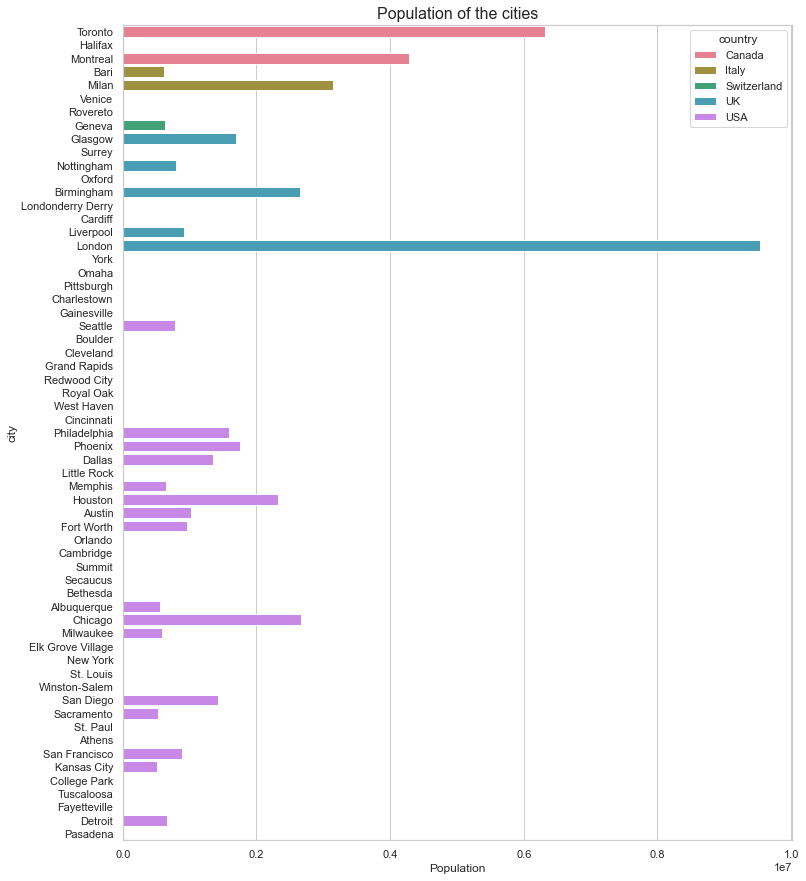

In [219]:
fig = plt.figure(figsize=(12, 15))
#sns.set_theme(style="whitegrid")
sns.barplot(y = "city", x = "Population", data=ddf, palette = "husl", hue = "country", dodge=False)
plt.title('Population of the cities', fontsize=16)
plt.show()

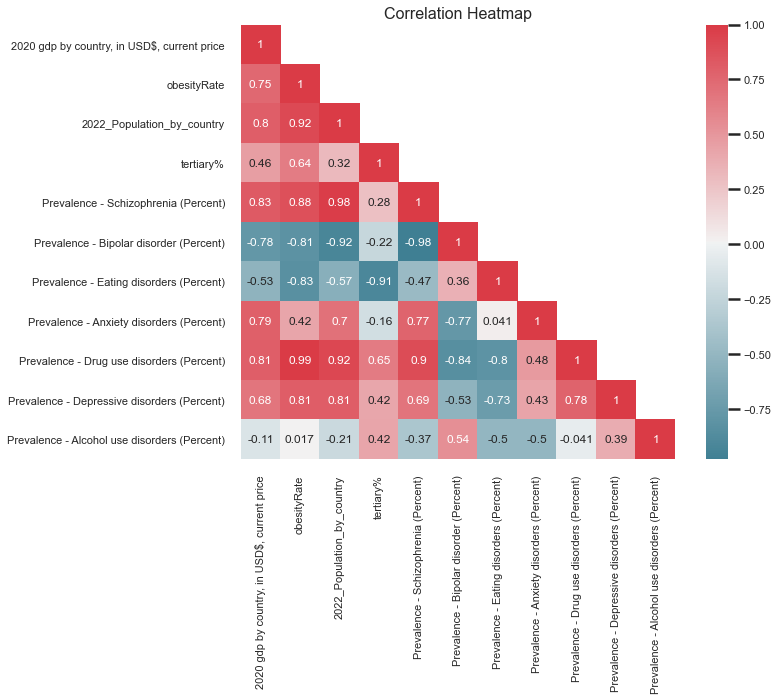

In [204]:
fig = plt.figure(figsize=(11, 8))
ddd = ddf
ddd.drop("Population", axis = 1, inplace = True)
ddd.drop("USD", axis = 1, inplace = True)
corr = ddd.corr()
sns.set_context('poster', font_scale=0.5)
mask = np.array(ddd.corr())
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap=cmap, square = True, cbar=True, annot=True)

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [ ]:
trytry = df
trytry.drop("2020 gdp by country, in USD$, current price", axis = 1, inplace = True)
fig = plt.figure(figsize=(11, 8))
corr = df.corr()
sns.set_context('poster', font_scale=0.5)
mask = np.array(df.corr())
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap=cmap, square = True, cbar=True, annot=True)

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

<h1>USEFUL VISUALIZATION TOOLS

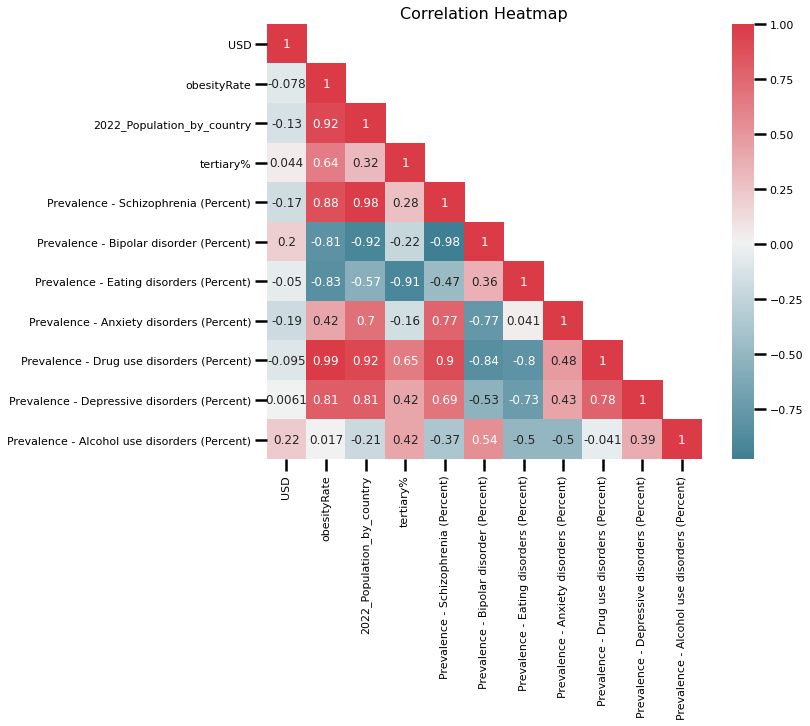

In [103]:
fig = plt.figure(figsize=(11, 8))
corr = df.corr()
sns.set_context('poster', font_scale=0.5)
mask = np.array(df.corr())
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap=cmap, square = True, cbar=True, annot=True)

plt.title('Correlation Heatmap', fontsize=16)
plt.show()
fig.savefig("Correlation Heatmap.png")

<Figure size 1080x720 with 0 Axes>

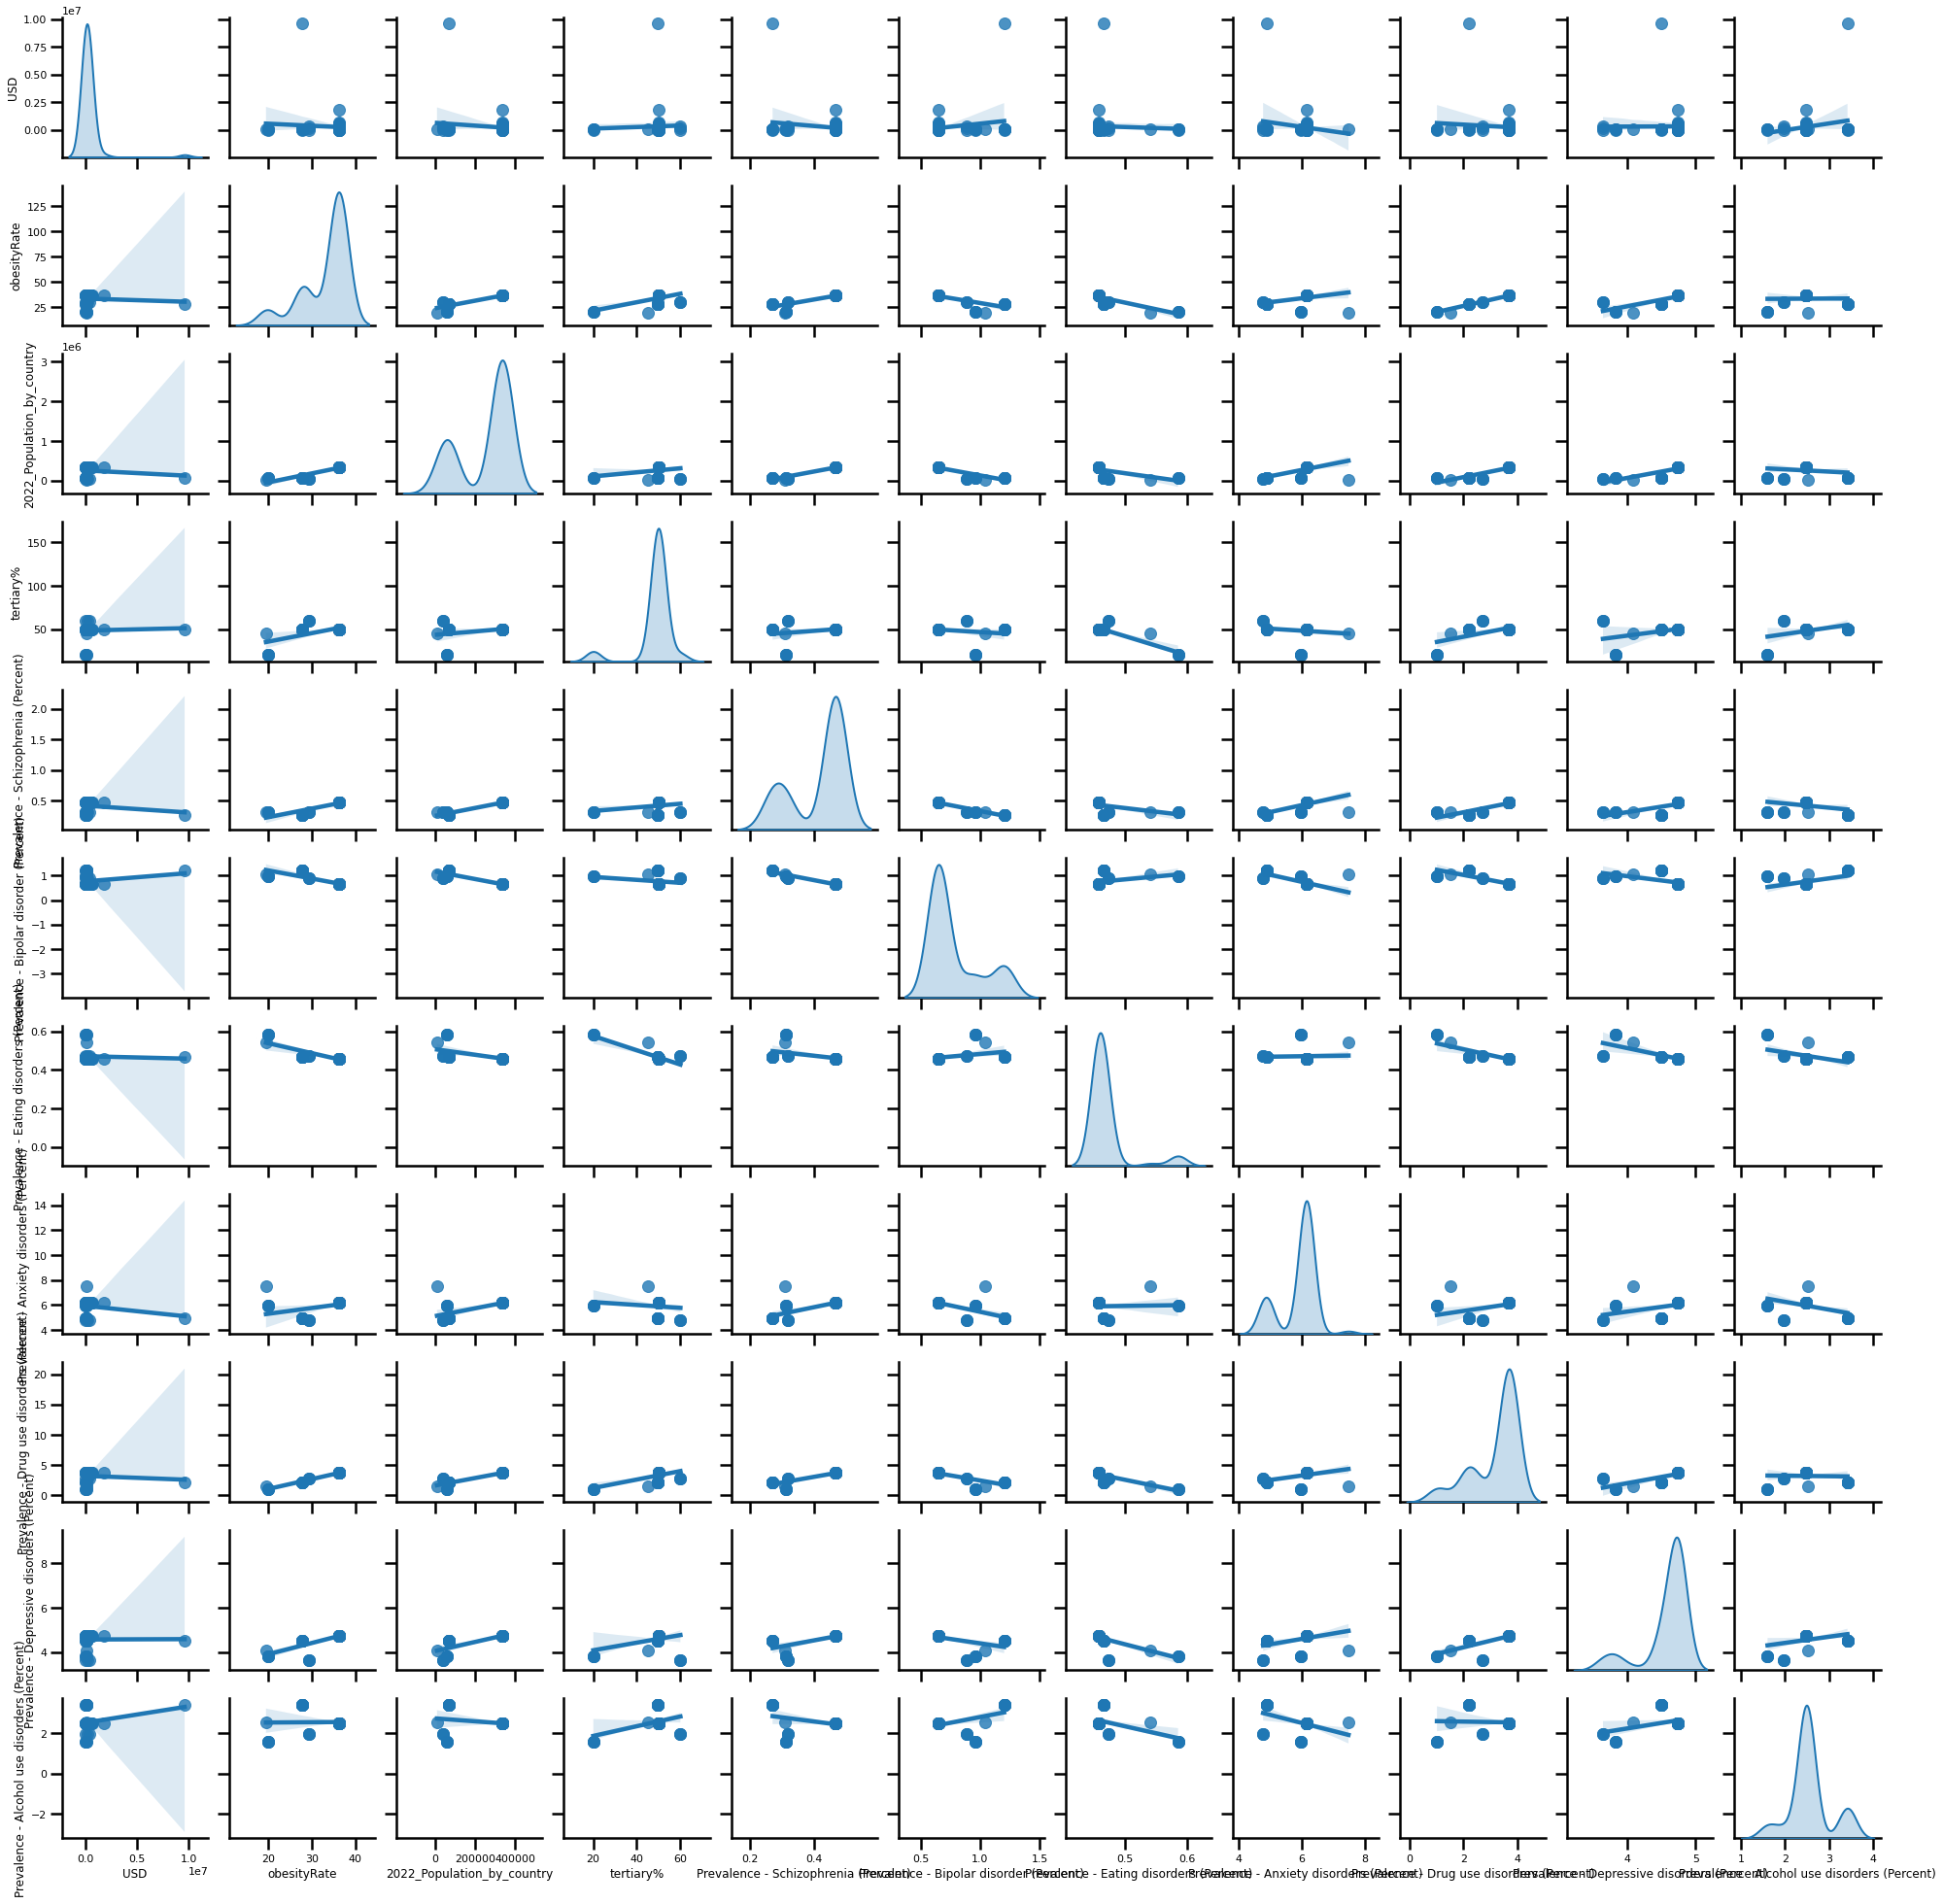

In [104]:
fig = plt.figure(figsize=(15, 10))
sns.pairplot(df, diag_kind = 'kde', kind = "reg")

In [134]:
fig = plt.figure(figsize=(10, 90))
fig = px.bar(df, y=["Prevalence - Schizophrenia (Percent)",
                    "Prevalence - Bipolar disorder (Percent)",
                    "Prevalence - Anxiety disorders (Percent)",
                    "Prevalence - Eating disorders (Percent)",
                    "Prevalence - Drug use disorders (Percent)",
                    "Prevalence - Depressive disorders (Percent)",
                    "Prevalence - Alcohol use disorders (Percent)"], 
             x="country")
fig.show()

<Figure size 720x6480 with 0 Axes>

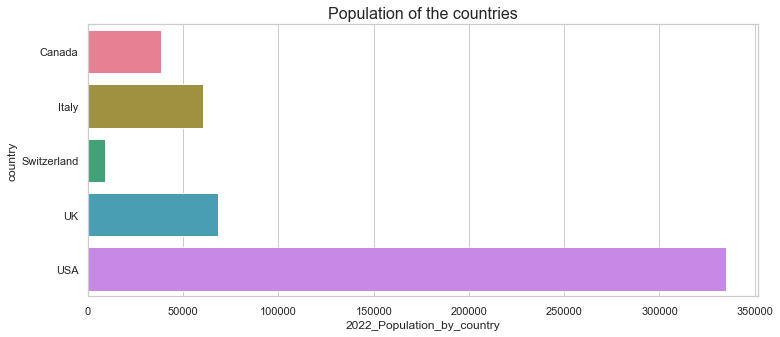

In [106]:
fig = plt.figure(figsize=(12, 5))
sns.set_theme(style="whitegrid")
sns.barplot(y="country", x="2022_Population_by_country", data=df, palette = "husl")
plt.title('Population of the countries', fontsize=16)
plt.show()

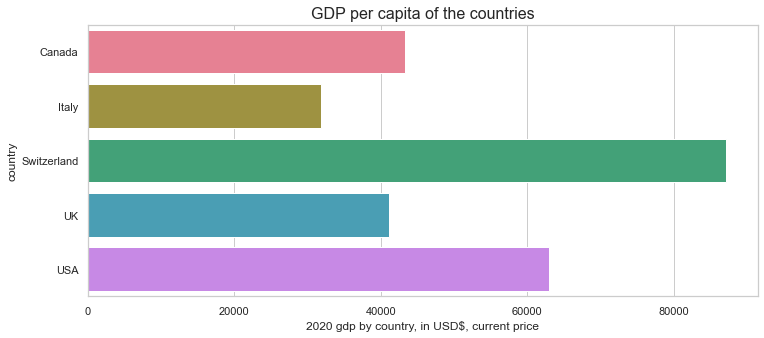

In [210]:
fig = plt.figure(figsize=(12, 5))
sns.set_theme(style="whitegrid")
sns.barplot(y="country", x="2020 gdp by country, in USD$, current price", data=ddf, palette = "husl")
plt.title('GDP per capita of the countries', fontsize=16)
plt.show()

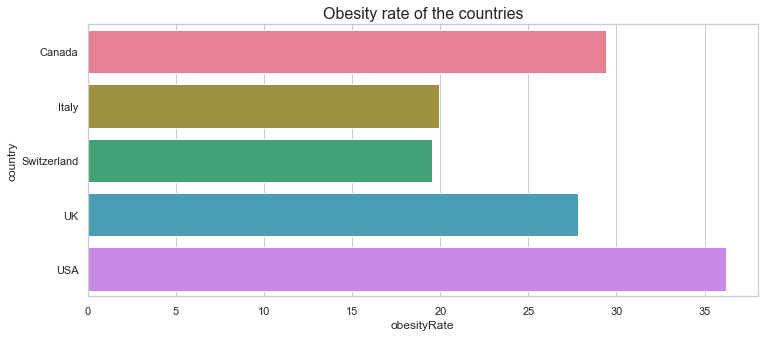

In [107]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(y="country", x="obesityRate", data=df, palette = "husl")
plt.title('Obesity rate of the countries', fontsize=16)
plt.show()

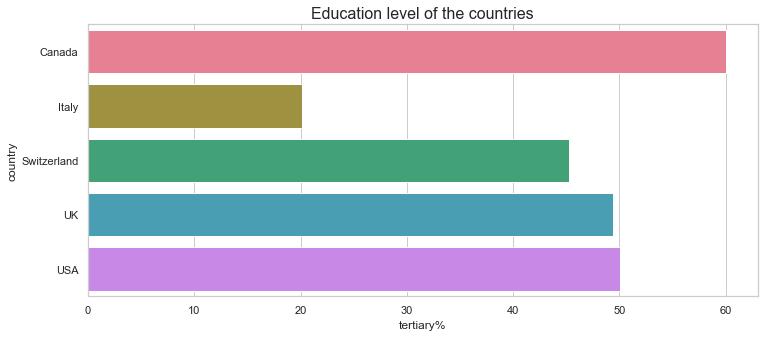

In [108]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(y="country", x="tertiary%", data=df, palette = "husl")
plt.title('Education level of the countries', fontsize=16)
plt.show()

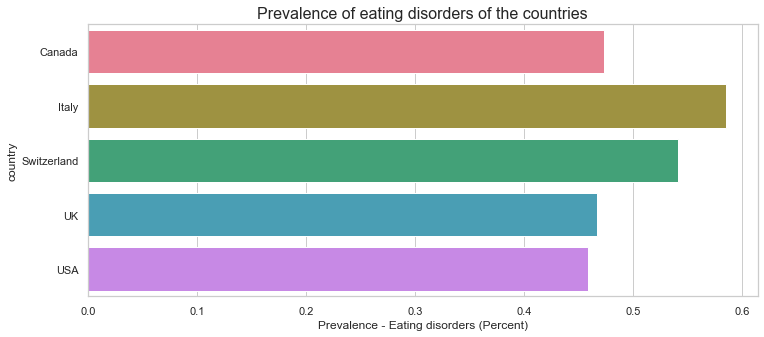

In [109]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x= "Prevalence - Eating disorders (Percent)", y="country", data=df, palette = "husl")
plt.title('Prevalence of eating disorders of the countries', fontsize=16)
plt.show()

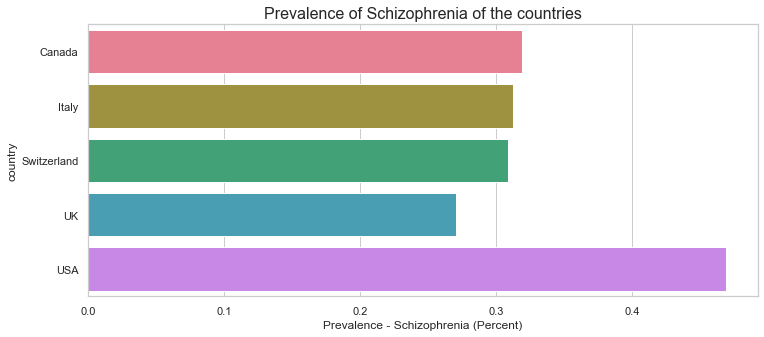

In [110]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x="Prevalence - Schizophrenia (Percent)", y="country", data=df, palette = "husl")
plt.title('Prevalence of Schizophrenia of the countries', fontsize=16)
plt.show()

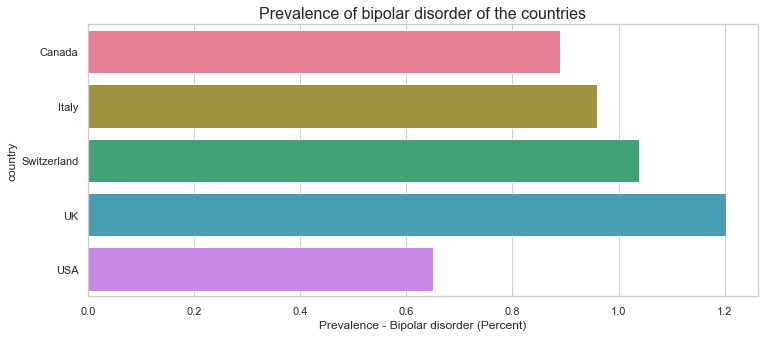

In [111]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x="Prevalence - Bipolar disorder (Percent)", y="country", data=df, palette = "husl")
plt.title('Prevalence of bipolar disorder of the countries', fontsize=16)
plt.show() 

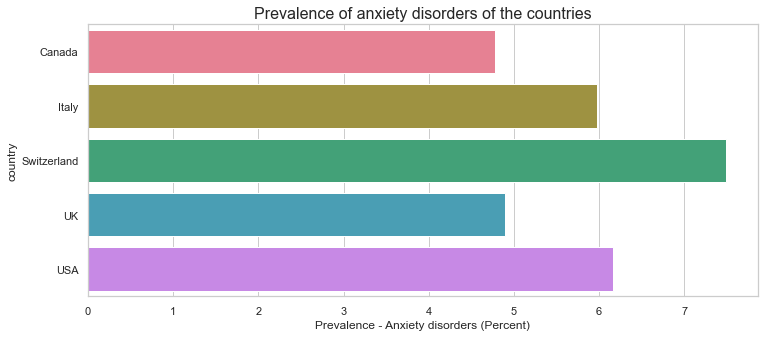

In [112]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x="Prevalence - Anxiety disorders (Percent)", y="country", data=df, palette = "husl")
plt.title('Prevalence of anxiety disorders of the countries', fontsize=16)
plt.show()

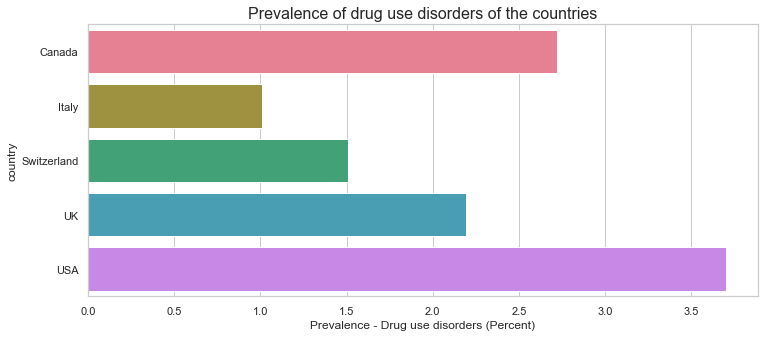

In [113]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x="Prevalence - Drug use disorders (Percent)", y="country", data=df, palette = "husl")
plt.title('Prevalence of drug use disorders of the countries', fontsize=16)
plt.show()

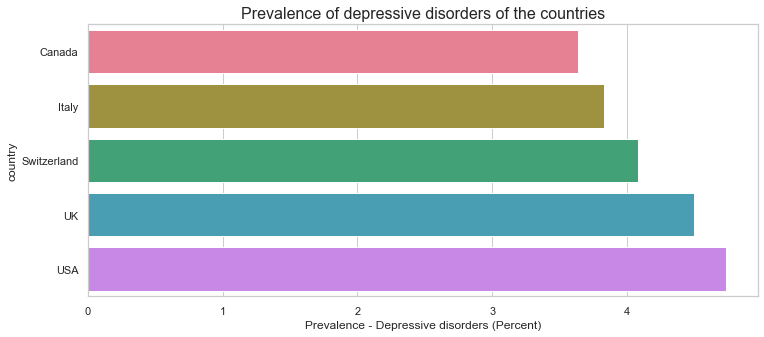

In [114]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x="Prevalence - Depressive disorders (Percent)", y="country", data=df, palette = "husl")
plt.title('Prevalence of depressive disorders of the countries', fontsize=16)
plt.show()

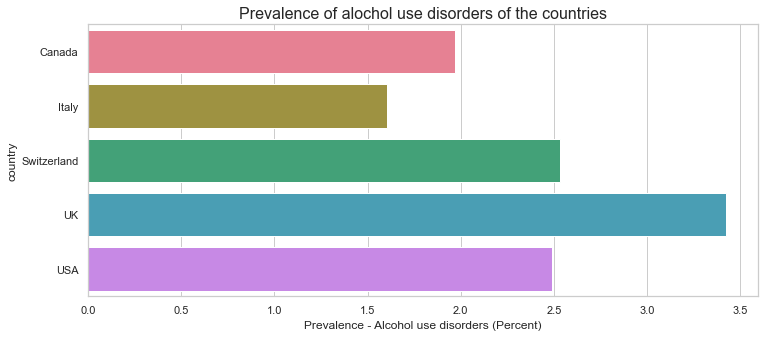

In [115]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x="Prevalence - Alcohol use disorders (Percent)", y="country", data=df, palette = "husl")
plt.title('Prevalence of alochol use disorders of the countries', fontsize=16)
plt.show()

In [116]:
dd = pd.merge (cgdp_df, obesity, how = "left", on = "country")
dd = pd.merge (dd, edu, how = "left", on = "country")
dd = pd.merge (dd, mental, how = "left", on = "country")

#Since there is duplicated population column, one can be dropped
ddd = dd.drop("pop2022_y", axis = 1)
ddd.rename(columns = {'pop2022_x':'2022_Population_by_country'}, inplace = True)
ddd['sum'] = ddd['Prevalence - Schizophrenia (Percent)']+ddd['Prevalence - Bipolar disorder (Percent)'] +ddd['Prevalence - Eating disorders (Percent)'] + ddd['Prevalence - Anxiety disorders (Percent)']+ ddd['Prevalence - Drug use disorders (Percent)']+ddd['Prevalence - Depressive disorders (Percent)']+ddd['Prevalence - Alcohol use disorders (Percent)']
ddd

,country,"2020 gdp by country, in USD$, current price",obesityRate,2022_Population_by_country,tertiary%,...,Prevalence - Anxiety disorders (Percent),Prevalence - Drug use disorders (Percent),Prevalence - Depressive disorders (Percent),Prevalence - Alcohol use disorders (Percent),sum
0,Canada,43258.264,29.400,38388.419,60.000,...,4.774,2.722,3.635,1.969,14.783
1,Switzerland,87100.415,19.500,8773.637,45.300,...,7.485,1.507,4.085,2.535,17.500
2,UK,41098.079,27.800,68497.907,49.400,...,4.898,2.191,4.500,3.421,16.950
3,Italy,31834.973,19.900,60262.770,20.100,...,5.978,1.011,3.828,1.606,14.281
4,USA,63027.680,36.200,334805.269,50.100,...,6.164,3.700,4.734,2.490,18.666


In [117]:
ddd['sum'].mean()

16.43583766705448

In [118]:
ddd.columns

Index(['country', '2020 gdp by country, in USD$, current price', 'obesityRate',
       '2022_Population_by_country', 'tertiary%',
       'Prevalence - Schizophrenia (Percent)',
       'Prevalence - Bipolar disorder (Percent)',
       'Prevalence - Eating disorders (Percent)',
       'Prevalence - Anxiety disorders (Percent)',
       'Prevalence - Drug use disorders (Percent)',
       'Prevalence - Depressive disorders (Percent)',
       'Prevalence - Alcohol use disorders (Percent)', 'sum'],
      dtype='object')

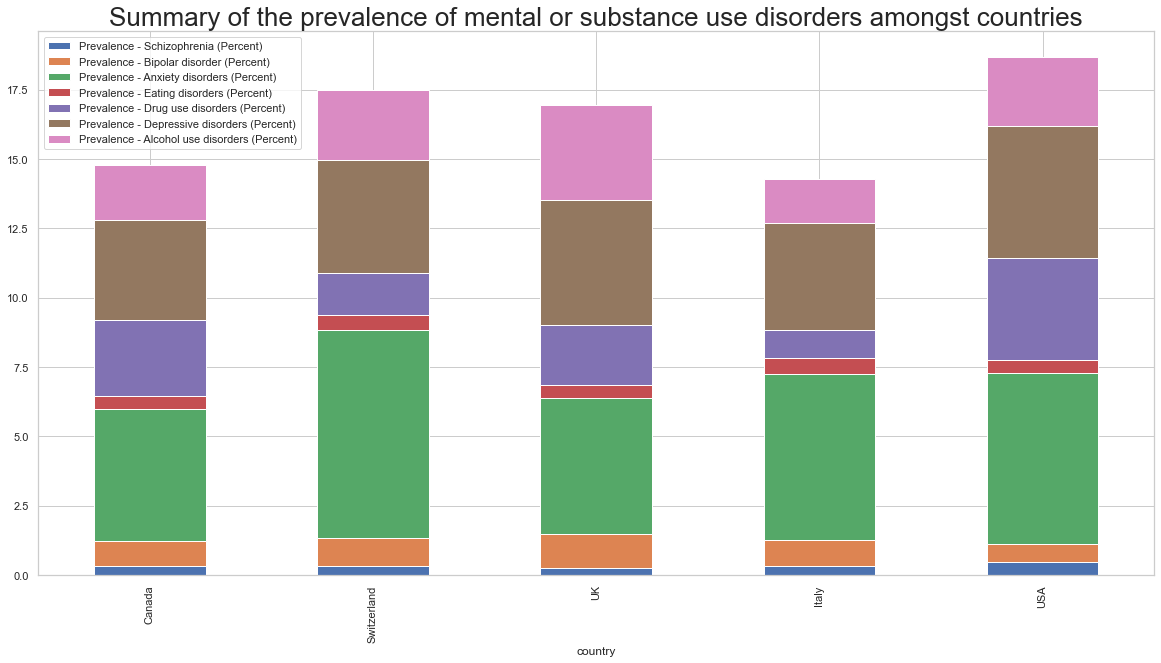

In [129]:
ax = ddd
ax.plot(x="country", y=["Prevalence - Schizophrenia (Percent)",
    "Prevalence - Bipolar disorder (Percent)",
    "Prevalence - Anxiety disorders (Percent)",
    "Prevalence - Eating disorders (Percent)",
    "Prevalence - Drug use disorders (Percent)",
    "Prevalence - Depressive disorders (Percent)",
    "Prevalence - Alcohol use disorders (Percent)"], kind="bar",figsize=(20,10),stacked=True)
plt.title('Summary of the prevalence of mental or substance use disorders amongst countries', fontsize=26)
plt.show()

In [120]:
df[df['country'] == "Switzerland"]

,city,w/o city GDP,country,USD,obesityRate,...,Prevalence - Eating disorders (Percent),Prevalence - Anxiety disorders (Percent),Prevalence - Drug use disorders (Percent),Prevalence - Depressive disorders (Percent),Prevalence - Alcohol use disorders (Percent)
7,Geneva,,Switzerland,57444.886,19.500,...,0.541,7.485,1.507,4.085,2.535


In [121]:
cusa = df[df['country'] == "USA"]
cusa.drop(cusa.iloc[:, 4:], axis=1, inplace=True)
cusa

,city,w/o city GDP,country,USD
18,Omaha,,USA,69122.853
19,Pittsburgh,,USA,153369.717
20,Charlestown,*,USA,63027.680
21,Gainesville,,USA,11879.587
22,Seattle,,USA,426939.963
23,Boulder,,USA,29682.206
24,Cleveland,,USA,4910.599
25,Grand Rapids,,USA,61371.686
26,Redwood City,*,USA,63027.680
27,Royal Oak,*,USA,63027.680


In [122]:
cuk = df[df['country'] == "UK"]
cuk.drop(cuk.iloc[:, 4:], axis=1, inplace=True)
cuk

,city,w/o city GDP,country,USD
8,Glasgow,,UK,46776.180
9,Surrey,*,UK,41098.079
10,Nottingham,*,UK,41098.079
11,Oxford,*,UK,41098.079
12,Birmingham,,UK,32442.520
13,Londonderry Derry,,UK,28321.260
14,Cardiff,,UK,43915.740
15,Liverpool,,UK,36815.460
16,London,,UK,9623934.650
17,York,*,UK,41098.079


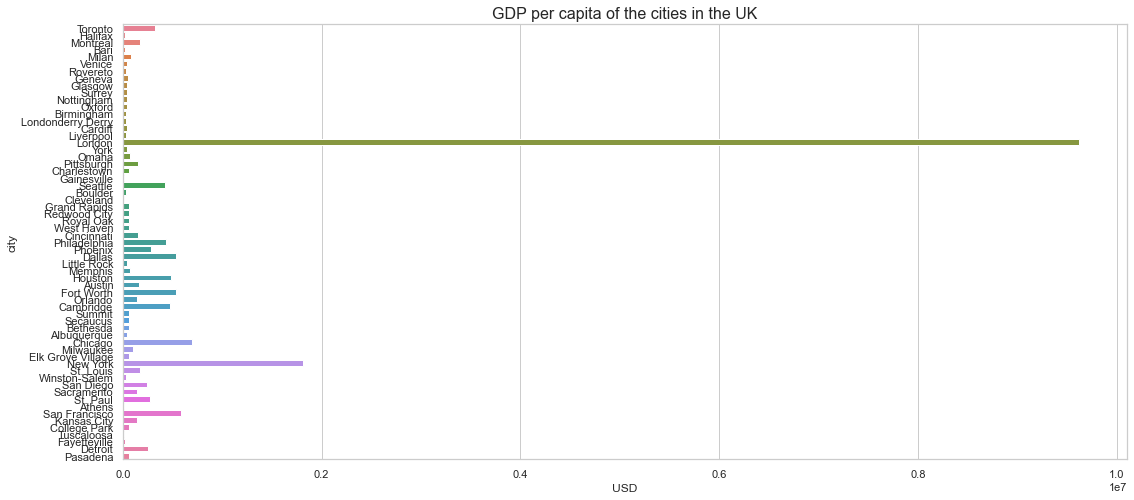

In [135]:
fig = plt.figure(figsize=(18, 8))
sns.barplot(x="USD", y="city", data=df, palette = "husl")
plt.title('GDP per capita of the cities in the UK', fontsize=16)
plt.show()

In [124]:
ci = df[df['country'] == "Italy"]
ci.drop(ci.iloc[:, 4:], axis=1, inplace=True)
ci

,city,w/o city GDP,country,USD
3,Bari,,Italy,27532.000
4,Milan,,Italy,78381.000
5,Venice,,Italy,40674.000
6,Rovereto,*,Italy,31834.973


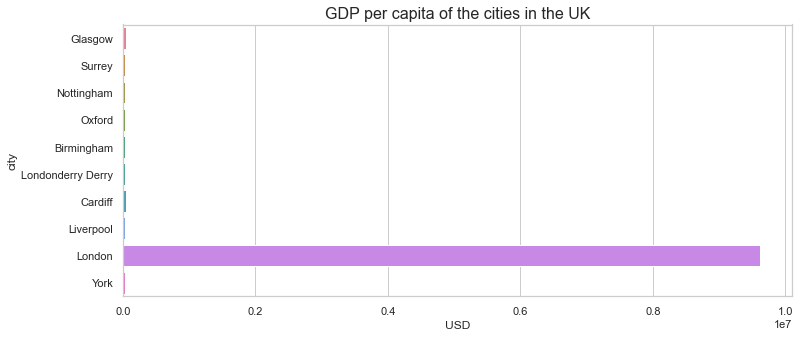

In [125]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x="USD", y="city", data=cuk, palette = "husl")
plt.title('GDP per capita of the cities in the UK', fontsize=16)
plt.show()

In [126]:
cc = df[df['country'] == "Canada"]
dd = df[df['country'] == "Switzerland"]
cc = pd.concat([cc,ci,dd])
cc.drop(cc.iloc[:, 4:], axis=1, inplace=True)
cc

,city,w/o city GDP,country,USD
0,Toronto,,Canada,328907.280
1,Halifax,,Canada,17776.200
2,Montreal,,Canada,173076.540
3,Bari,,Italy,27532.000
4,Milan,,Italy,78381.000
5,Venice,,Italy,40674.000
6,Rovereto,*,Italy,31834.973
7,Geneva,,Switzerland,57444.886


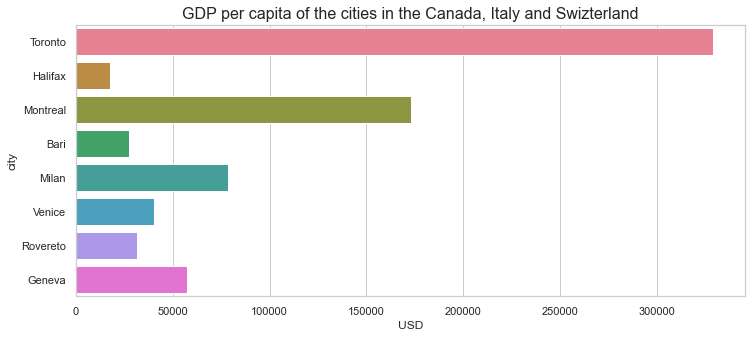

In [136]:
fig = plt.figure(figsize=(12, 5))
sns.barplot(x="USD", y="city", data=cc, palette = "husl")
plt.title('GDP per capita of the cities in the Canada, Italy and Swizterland', fontsize=16)
plt.show()